In [50]:
import imageio as io
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

%matplotlib inline

import os
print(os.getcwd())

import torch

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# SAM utils from their examples
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        #color = np.array([30/255, 144/255, 255/255, 0.6])
        color = np.array([255/255, 0/255, 0/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_anns(anns):
    if len(anns) == 0:
        return
    
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    
    ax.imshow(img)


/home/filip-grigorov/code/IsaacLab/notebooks
cuda:0


In [51]:
MODEL_TYPE = "vit_h" #vit_l, vit_b
CHECKPOINT = "sam_checkpoint/sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

/tmp/ipykernel_2505187/840596071.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sample_img = io.imread(IMG_PATH)


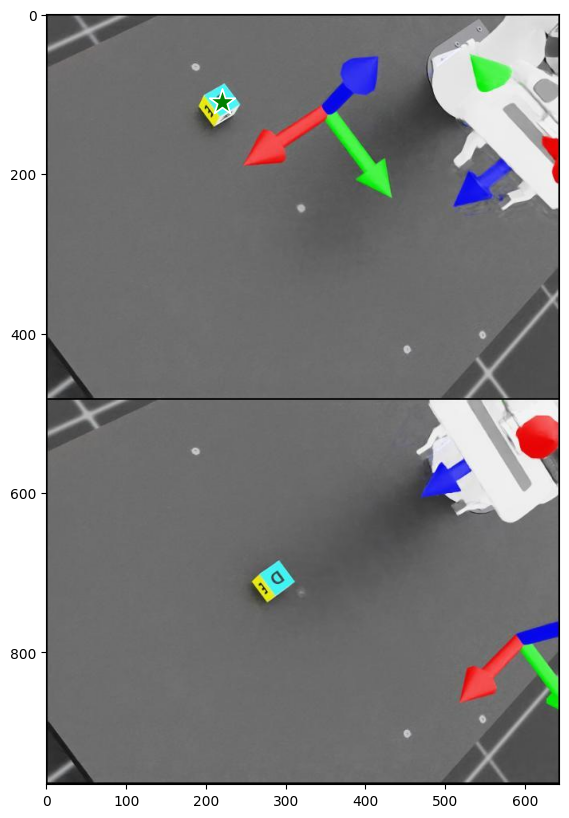

In [52]:
IMG_PATH = "data/franka_list_cube_rgb.jpg"
sample_img = io.imread(IMG_PATH)

input_point = np.array([[220, 110]])
input_label = np.array([1])

plt.figure(figsize=(10, 10))
plt.imshow(sample_img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [53]:
predictor = SamPredictor(sam)
predictor.set_image(sample_img)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

print(masks.shape)
print(scores.shape)

max_idx = np.argmax(scores)
masks = masks[max_idx:max_idx+1, ...]
scores = scores[max_idx:max_idx+1]

print(masks.shape)
print(scores.shape)

(3, 966, 644)
(3,)
(1, 966, 644)
(1,)


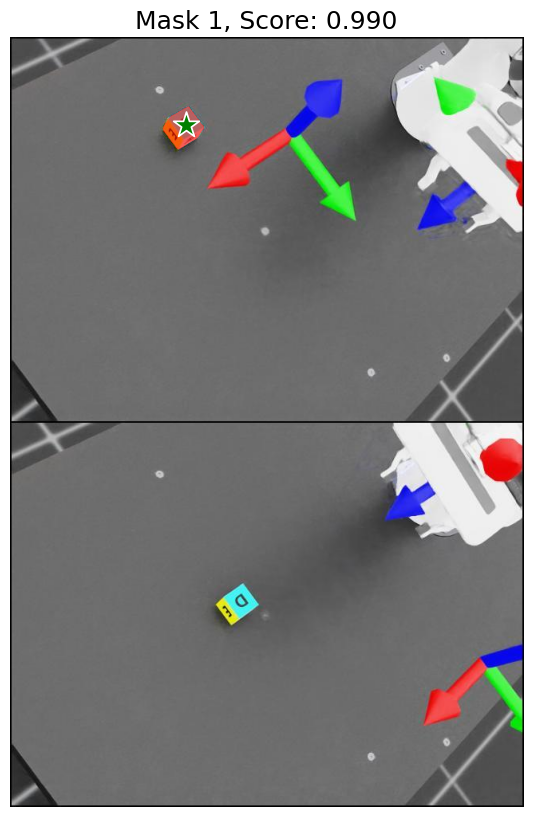

In [54]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(sample_img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

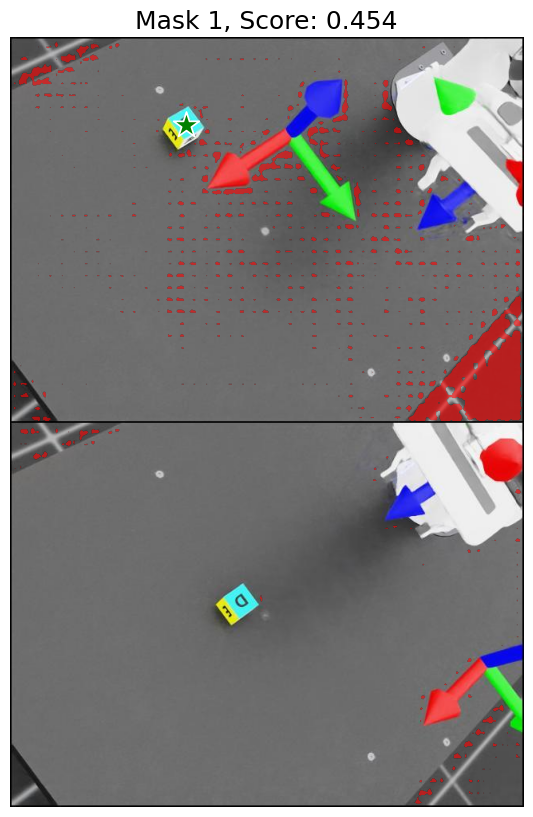

In [55]:
masks, scores, logits = predictor.predict(
    multimask_output=True,
)

max_idx = np.argmax(scores)
masks = masks[max_idx:max_idx+1, ...]
scores = scores[max_idx:max_idx+1]

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(sample_img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 


62
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


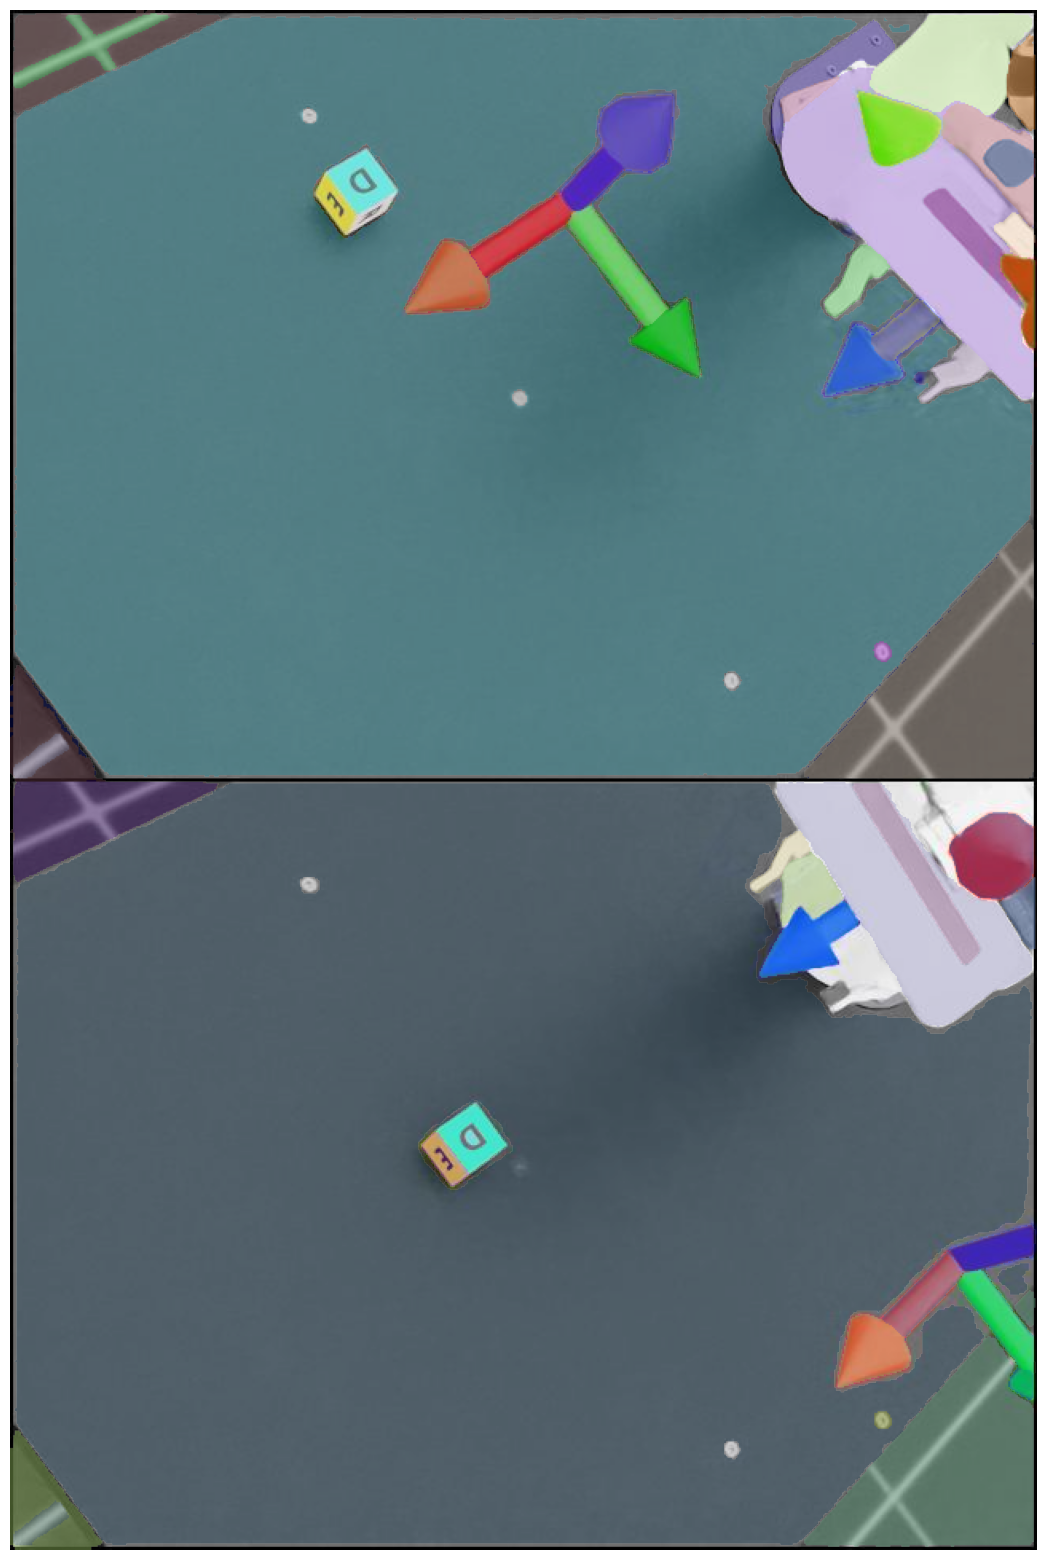

: 

In [56]:
# automatic mask generation
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(sample_img)
print(len(masks))
print(masks[0].keys())

plt.figure(figsize=(20,20))
plt.imshow(sample_img)
show_anns(masks)
plt.axis('off')
plt.show() 